# 作业第7周：CGAN练习

1.仿照课件示例的GAN生成网络代码，实现Fashion_mnist数据集的条件生成对抗网络CGAN。<BR>
    （对于感觉困难同学，可以降级选择完成GAN练习，计80%）

In [1]:
#首先执行GPU资源分配代码，勿删除。
import GPU
GPU.show()
GPU.alloc(0,1024)

Sun Jun 18 23:54:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:02:00.0 Off |                  N/A |
| 44%   48C    P2   123W / 350W |  22501MiB / 24268MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 52%   

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from IPython import display
import tensorflow as tf

In [3]:
fashion_mnist=tf.keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

In [4]:
train_images=train_images.reshape(train_images.shape[0],28,28,1).astype('float32')
train_images=(train_images-127.5)/127.5

In [5]:
buffer_size=60000
batch_size=256

In [6]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(buffer_size).batch(batch_size)

In [7]:
def make_generator_model():
    model=tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape==(None,7,7,256)

    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert  model.output_shape==(None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2,2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2), padding='same', use_bias=False,activation='tanh'))
    assert model.output_shape==(None, 28,28,1)
    return model

In [8]:
generator=make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [9]:
def make_discriminator_model():
    model=tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2), padding='same',input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [10]:
discriminator=make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [39]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output,fake_output):
    real_loss=cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss=cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss=real_loss+fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [40]:
epochs=50
noise_dim=100
num_examples_to_generate=16

In [41]:
seed=tf.random.normal([num_examples_to_generate,noise_dim])

In [42]:
@tf.function
def train_step(images):
    noise=tf.random.normal([batch_size,noise_dim])

    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
        generated_images=generator(noise,training=True)
        
        real_output=discriminator(images,training=True)
        fake_output=discriminator(generated_images,training=True)
        
        gen_loss=generator_loss(fake_output)
        disc_loss=discriminator_loss(real_output,fake_output)

    gradients_of_generator=gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator= disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator,generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss,disc_loss

In [43]:
import time
def train(dataset,epochs):
    for epoch in range(epochs):
        start=time.time()

        for i,image_batch in enumerate(dataset):
            g,d=train_step(image_batch)
            print("batch %d, gen_loss %f, disc_loss %f"%(i,g.numpy(),d.numpy()))

        display.clear_output(wait=True)
        generate_images(generator,seed)

        if(epoch+1)%5==0:
            generator.save(f'save/3200105974/gan_fashion-mnist_tf{epoch+1}.h5')
            
        print("Time for epoch{} is {} sec".format(epoch+1,time.time()-start))

In [44]:
def generate_images(model,test_input):
    
    predictions=model(test_input,training=False)
    
    fig=plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0]*127.5+127.5,cmap='gray')
        
        plt.axis('off')
    plt.show()
        



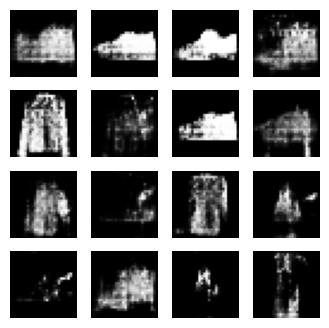

Time for epoch50 is 4.228191375732422 sec


In [45]:
train(train_dataset,epochs)

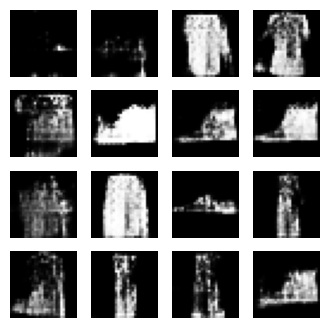

In [46]:
test_input=tf.random.normal([16,100])
generate_images(generator,test_input)